## You can find the recording here: https://youtu.be/UFCLIGWKs9E

## **סעיפים א, ב, ג, ד**

In [ ]:
import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd

import os

from google.colab import drive
drive.mount('/content/drive')
# for the check need to change the directory according to the user of google drive
dir = "/content/drive/MyDrive/Deep Learning/maman13"
labels_file = "diabetes.csv"

diabetes_df = pd.read_csv(os.path.join(dir,labels_file), sep='\t')
num_classes = 10
deciles = pd.qcut(diabetes_df.loc[:,'Y'], num_classes, labels=list(range(num_classes)))
diabetes_df['Class'] = deciles


Mounted at /content/drive


In [ ]:
class DiabetesDataset(Dataset):
  
  def __init__(self, diabetes_df, transform=None, target_transform=None):
    self.transform = transform
    self.target_transform = target_transform
    self.diabetes_df = diabetes_df

  def __len__(self):
    return len(self.diabetes_df)

  def __getitem__(self, idx):
    #print("THE ID: ", idx)
    sample = self.diabetes_df.iloc[idx].to_numpy()
    if self.transform:
      sample = self.transform(sample)
    
    label = torch.tensor(int(sample[-1]))
    features = torch.tensor(sample[:-1], dtype=torch.float32)
    return features, label
  
    
transform = None 
diabetesDataset_all = DiabetesDataset(diabetes_df, transform=transform)

# **סעיף ו**

In [ ]:
from torch.utils.data import DataLoader

diabetesDataLoader = DataLoader(diabetesDataset_all, batch_size=10, shuffle=True)

# **סעיף ז**

In [ ]:
features, labels = next(iter(diabetesDataLoader))
batch_size, number_features = features.shape

for i in range(batch_size):
  print("label = ",labels[i], "features = ", features[i], sep = '\t')


label = 	tensor(7)	features = 	tensor([ 36.0000,   1.0000,  27.8000,  73.0000, 153.0000, 104.4000,  42.0000,
          4.0000,   3.4965,  73.0000, 201.0000])
label = 	tensor(9)	features = 	tensor([ 44.0000,   1.0000,  31.4000, 115.0000, 165.0000,  97.6000,  52.0000,
          3.0000,   4.3438,  89.0000, 293.0000])
label = 	tensor(3)	features = 	tensor([ 20.0000,   1.0000,  22.9000,  87.0000, 191.0000, 128.2000,  53.0000,
          4.0000,   3.8918,  85.0000, 113.0000])
label = 	tensor(9)	features = 	tensor([ 29.0000,   1.0000,  30.0000,  85.0000, 180.0000,  93.4000,  43.0000,
          4.0000,   5.3845,  88.0000, 310.0000])
label = 	tensor(6)	features = 	tensor([ 71.0000,   2.0000,  26.5000, 105.0000, 281.0000, 173.6000,  55.0000,
          5.0000,   5.5683,  84.0000, 196.0000])
label = 	tensor(2)	features = 	tensor([ 23.0000,   2.0000,  18.0000,  78.0000, 171.0000,  96.0000,  48.0000,
          4.0000,   4.9053,  92.0000,  94.0000])
label = 	tensor(1)	features = 	tensor([ 39.0000,   2

## **סעיף ח, ט, י**

In [ ]:
from torch import nn


class DiabetesModel(torch.nn.Module):
    def __init__(self, input_size, output_size, activation=torch.nn.ReLU(), with_bias=True):
        super(DiabetesModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32, bias=with_bias),
            activation,
            nn.Linear(32, 16, bias=with_bias),
            activation,
            nn.Linear(16, output_size, bias=with_bias),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)

def printDiabetesModelParams(diabetesModel):
  print('\n\nModel params:')
  num_parameters = 0
  for i, param in enumerate(diabetesModel.parameters()):
      print('tensor_{}_shape={}'.format(i, param.shape))
      num_parameters += torch.numel(param)
  print('number of model params ', num_parameters)

def getLossAndOptimizerAccordingToModel(diabetesModel):
  CE_loss = nn.NLLLoss()
  optimizer = torch.optim.SGD(diabetesModel.parameters(), lr=0.01)
  return CE_loss, optimizer


In [ ]:
def iterate_train_batch(optimizer, CE_loss, diabModel, features, labels):
  optimizer.zero_grad()
  score = diabModel(features)

  loss = CE_loss(score, labels)
  loss.backward()
  optimizer.step()

  predicted_labels = score.argmax(dim=1)
  acc = (predicted_labels == labels).sum()/len(labels)
  return loss.detach(), acc.detach()


In [ ]:
# Train Single Epoch:
def train_single_epoch(train_dataloader, optimizer, CE_loss, diabModel, device, drop_Y = False):
  num_batches = len(train_dataloader)
  #print("The number of batches is ", num_batches)
  loss = torch.zeros(num_batches)
  acc  = torch.zeros(num_batches)
  if(drop_Y):
    for idx, (features, labels) in enumerate(train_dataloader):
      features, labels = features.to(device), labels.to(device)
      loss[idx], acc[idx] = iterate_train_batch(optimizer, CE_loss, diabModel, features[:, :-1], labels)
  else:
    for idx, (features, labels) in enumerate(train_dataloader):
      features, labels = features.to(device), labels.to(device)
      loss[idx], acc[idx] = iterate_train_batch(optimizer, CE_loss, diabModel, features, labels)
    
    #print("Features in batch number :", idx)
    #print(features)
    #print("<========================================================================>")
    # loss[idx], acc[idx] = iterate_batch(optimizer, CE_loss, diabModel, features, labels)
  return loss, acc


In [ ]:
from tqdm import tqdm
epochs = 1000
num_records = 20
nun_epochs_report = int(epochs/num_records)

def training(epochs, train_dataloader, optimizer, CE_loss, diabModel, device, drop_Y = False):
  loss_train, acc_train = [], []
  loss_train_ep, acc_train_ep = torch.zeros(epochs), torch.zeros(epochs)
  
  diabModel = diabModel.to(device)
  for ne in (pbar := tqdm(range(epochs))):
    loss, acc = train_single_epoch(train_dataloader, optimizer, CE_loss, diabModel, device, drop_Y)
    loss_train.append(loss)
    acc_train.append(acc)
    loss_train_ep[ne] = loss.mean()
    acc_train_ep[ne] = acc.mean()
    if ne % nun_epochs_report == 0:
      pbar.set_description(f"training... epoch {ne + 1} of {epochs} loss= {loss_train_ep[ne]} acc={acc_train_ep[ne]}")
      #print('epoch={}, loss={}'.format(ne, loss_train_ep[ne]))  
  return loss_train_ep, acc_train_ep, torch.cat(loss_train), torch.cat(acc_train)


In [ ]:
import matplotlib_inline
import matplotlib.pyplot as plt

def performance_plot(loss, accuracy, text=''):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
  ax1.plot(loss)
  ax1.grid()
  ax1.set_title('CE loss ' + text)
  ax2.plot(accuracy)
  ax2.grid()
  ax2.set_title('accuracy ' + text)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device used', device)

device used cuda


In [ ]:
#defining an activation function for the model
activation = nn.LeakyReLU(0.1)

In [ ]:
def getLossAndAccuracy(diabModel, epochs, diabetesDataLoader, device, drop_Y = False):
  printDiabetesModelParams(diabModel)
  CE_loss, optimizer = getLossAndOptimizerAccordingToModel(diabModel)
  output = training(epochs, diabetesDataLoader, optimizer, CE_loss, diabModel, device=device, drop_Y = drop_Y)
  loss, accuracy = output[0], output[1]
  return loss, accuracy

In [ ]:
output_size_of_model = 10

# **Plotting the accuracy graph of loss and accuracy Y parameter excluded (whole dataset)**



Model params:
tensor_0_shape=torch.Size([32, 10])
tensor_1_shape=torch.Size([32])
tensor_2_shape=torch.Size([16, 32])
tensor_3_shape=torch.Size([16])
tensor_4_shape=torch.Size([10, 16])
tensor_5_shape=torch.Size([10])
number of model params  1050


training... epoch 951 of 1000 loss= 1.6656365394592285 acc=0.35777777433395386: 100%|██████████| 1000/1000 [02:14<00:00,  7.44it/s]


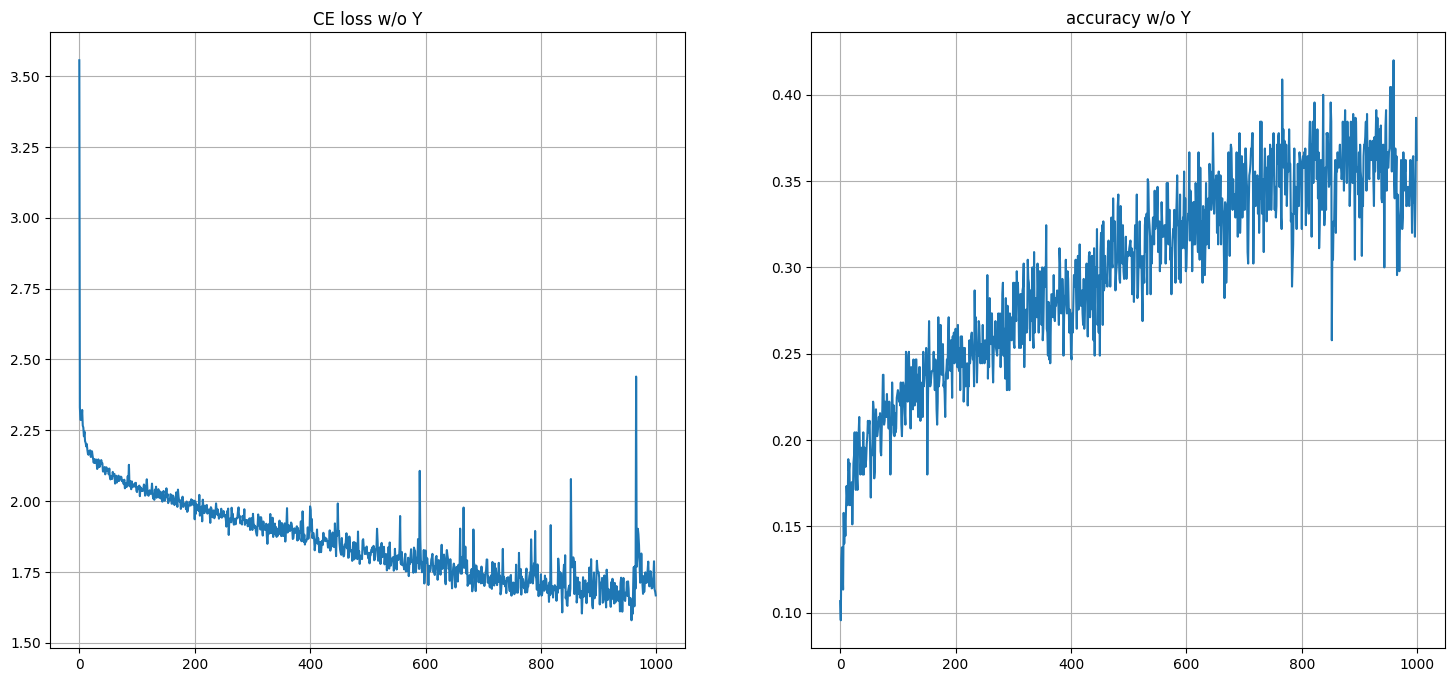

In [ ]:
diabModel = DiabetesModel(10, output_size_of_model, activation = activation)
loss, accuracy = getLossAndAccuracy(diabModel, epochs, diabetesDataLoader, device, drop_Y = True)
performance_plot(loss, accuracy, 'w/o Y')

# **Plotting the accuracy graph of loss and accuracy Y parameter included (whole dataset)**



Model params:
tensor_0_shape=torch.Size([32, 11])
tensor_1_shape=torch.Size([32])
tensor_2_shape=torch.Size([16, 32])
tensor_3_shape=torch.Size([16])
tensor_4_shape=torch.Size([10, 16])
tensor_5_shape=torch.Size([10])
number of model params  1082


training... epoch 951 of 1000 loss= 0.789314866065979 acc=0.6644444465637207: 100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


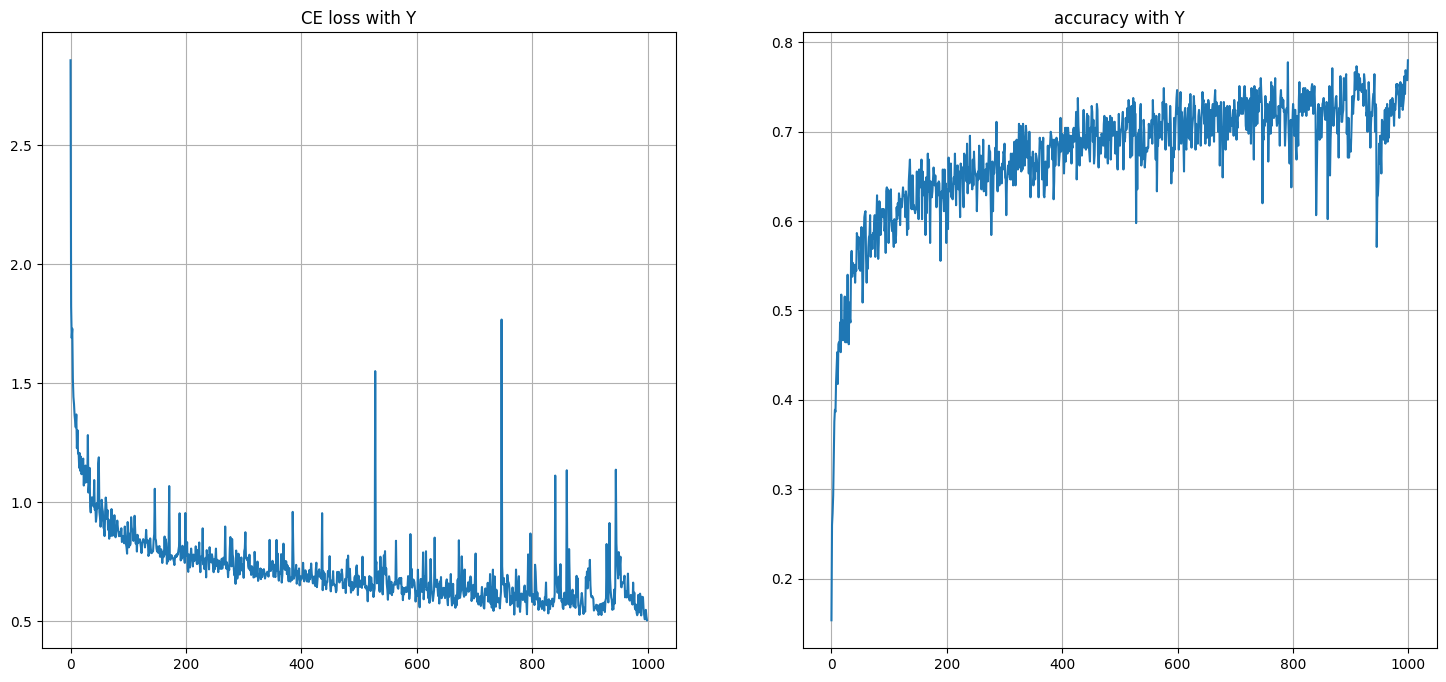

In [ ]:
diabModel = DiabetesModel(11, output_size_of_model, activation = activation)
loss, accuracy = getLossAndAccuracy(diabModel, epochs, diabetesDataLoader, device)
performance_plot(loss, accuracy, 'with Y')

# **סעיף י - חלוקה של הדאטא ל-20% טסט דאטא ו 80% של אימון**

In [ ]:
diab_training_df = diabetes_df.sample(frac=0.8, random_state=23)
diab_testing_df = diabetes_df.drop(diab_training_df.index)
#import numpy as npdf
#msk = np.random.rand(len(diabetes_df)) < 0.8
#diab_training_data = diabetes_df[msk]
#diab_testing_data = diabetes_df[~msk]

diab_train_dataset = DiabetesDataset(diab_training_df, transform=transform)
diab_test_dataset = DiabetesDataset(diab_testing_df, transform=transform)

train_dataloader = DataLoader(diab_train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(diab_test_dataset, batch_size=10, shuffle=False)

print("Number of batches in training ", len(train_dataloader))
print("Number of batches in testing ", len(test_dataloader))

#diab_testing_data
#diab_training_data

Number of batches in training  36
Number of batches in testing  9


# **Training on 80% training set with Y parameter excluded**



Model params:
tensor_0_shape=torch.Size([32, 10])
tensor_1_shape=torch.Size([32])
tensor_2_shape=torch.Size([16, 32])
tensor_3_shape=torch.Size([16])
tensor_4_shape=torch.Size([10, 16])
tensor_5_shape=torch.Size([10])
number of model params  1050


training... epoch 951 of 1000 loss= 1.6296496391296387 acc=0.37916669249534607: 100%|██████████| 1000/1000 [01:46<00:00,  9.39it/s]


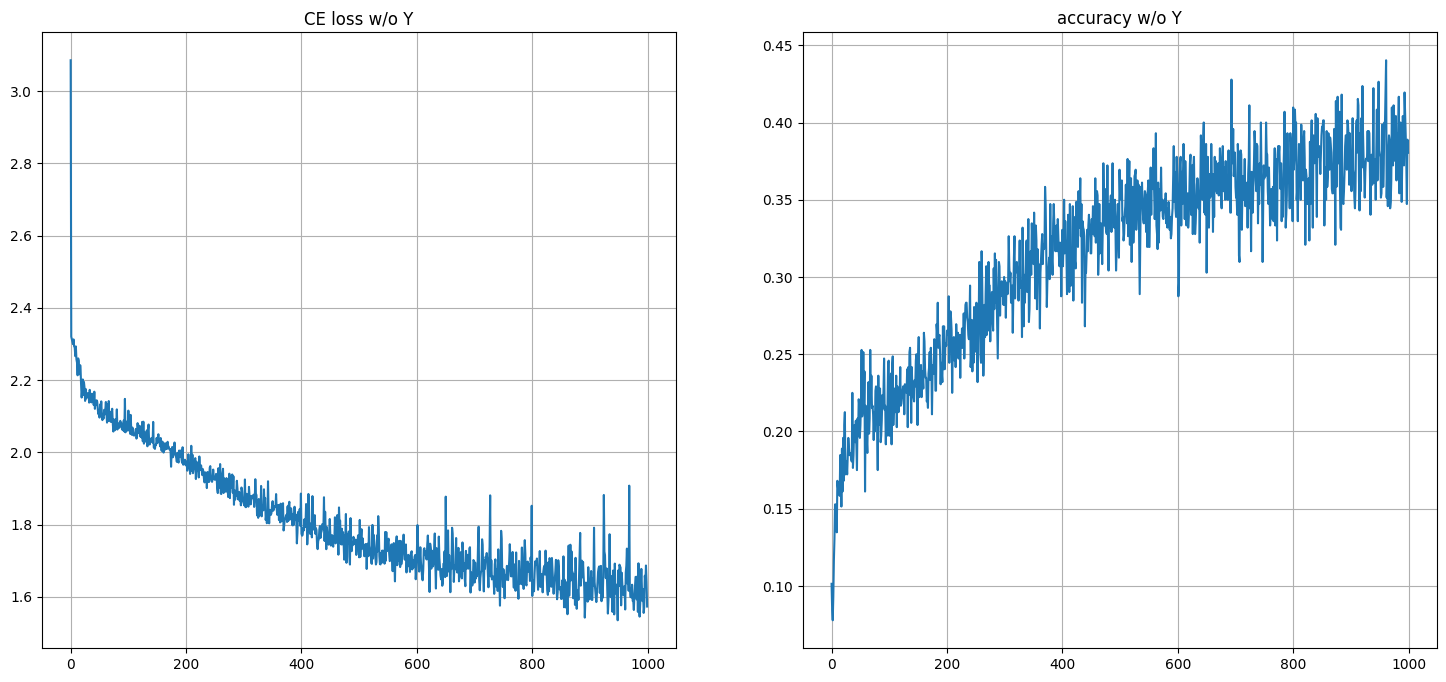

In [ ]:
diabModelYExcluded = DiabetesModel(10, output_size_of_model, activation = activation)
loss, accuracy = getLossAndAccuracy(diabModelYExcluded, epochs, train_dataloader, device, True)
performance_plot(loss, accuracy, 'w/o Y')    

# **Training on 80% training set with Y parameter included**



Model params:
tensor_0_shape=torch.Size([32, 11])
tensor_1_shape=torch.Size([32])
tensor_2_shape=torch.Size([16, 32])
tensor_3_shape=torch.Size([16])
tensor_4_shape=torch.Size([10, 16])
tensor_5_shape=torch.Size([10])
number of model params  1082


training... epoch 951 of 1000 loss= 0.49588680267333984 acc=0.7819444537162781: 100%|██████████| 1000/1000 [01:47<00:00,  9.34it/s]


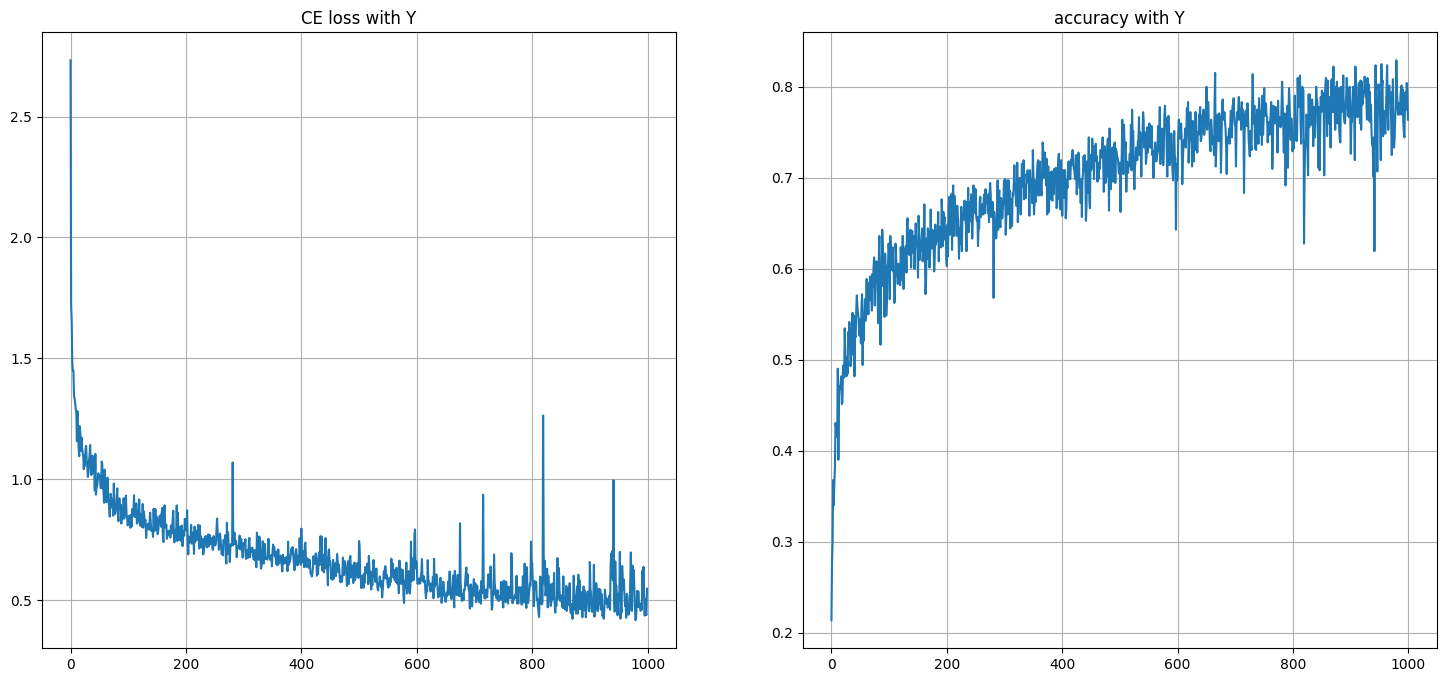

In [ ]:
diabModelYIncluded = DiabetesModel(11, output_size_of_model, activation = activation)
loss, accuracy = getLossAndAccuracy(diabModelYIncluded, epochs, train_dataloader, device)
performance_plot(loss, accuracy, 'with Y')  

# **Function for testing a batch**

In [ ]:
def iterate_test_batch(optimizer, CE_loss, diabModel, features, labels):
  score = diabModel(features)
  loss = CE_loss(score, labels)
  predicted_labels = score.argmax(dim=1)
  acc = (predicted_labels == labels).sum()/len(labels)
  return loss.detach(), acc.detach()

# **Function for testing the data**

In [ ]:
def test(train_dataloader,diabModel, device, drop_Y = False):
  CE_loss, optimizer = getLossAndOptimizerAccordingToModel(diabModel)
  num_batches = len(train_dataloader)
  loss = torch.zeros(num_batches)
  acc  = torch.zeros(num_batches)
  if(drop_Y):
    for idx, (features, labels) in enumerate(train_dataloader):
      features, labels = features.to(device), labels.to(device)
      loss[idx], acc[idx] = iterate_test_batch(optimizer, CE_loss, diabModel, features[:, :-1], labels)
  else:
    for idx, (features, labels) in enumerate(train_dataloader):
      features, labels = features.to(device), labels.to(device)
      loss[idx], acc[idx] = iterate_test_batch(optimizer, CE_loss, diabModel, features, labels)
  #loss_mean, loss_std = loss.mean(), loss.std()
  #acc_mean, acc_std = acc.mean(), acc.std()
  return loss, acc

In [ ]:
def print_statstics(x, text):
  print('{}: mean = {} and the std = {}'.format(text, x.mean(), x.std()))
  #print('epoch={}, loss={}'.format(ne, loss_train_ep[ne]))

In [ ]:
loss, accuracy = test(test_dataloader, diabModelYExcluded, device, drop_Y=True)
print_statstics(loss, 'loss w/o Y' )
print_statstics(accuracy, 'accuracy w/o Y' )

loss w/o Y: mean = 3.7295925617218018 and the std = 0.8140136003494263
accuracy w/o Y: mean = 0.12777778506278992 and the std = 0.11486707627773285


In [ ]:
loss, accuracy = test(test_dataloader, diabModelYIncluded, device, drop_Y=False)
print_statstics(loss, 'loss with Y' )
print_statstics(accuracy, 'accuracy with Y' )

loss with Y: mean = 1.3923085927963257 and the std = 0.8234162330627441
accuracy with Y: mean = 0.6222221851348877 and the std = 0.13944333791732788


# **סעיף יא**
We can see that the model with the Y is better than the model without the Y.
This makes sense, since 'Class' column is a function of Y, so when Y is included it gives more information on what to learn from, removing Y means we lose this information. 

# **סעיף יב**

In [ ]:
num_classes = 100
precentiles = pd.qcut(diabetes_df.loc[:,'Y'], num_classes, labels=list(range(num_classes)))
diabetes_df['Class'] = precentiles

# **סעיף יג**

# Define a dataset and a dataloader

In [ ]:
transform = None 
diabetesDataset_all = DiabetesDataset(diabetes_df, transform=transform)
diabetesDataLoader = DataLoader(diabetesDataset_all, batch_size=10, shuffle=True)


# Plot graph of model with Y excluded



Model params:
tensor_0_shape=torch.Size([32, 10])
tensor_1_shape=torch.Size([32])
tensor_2_shape=torch.Size([16, 32])
tensor_3_shape=torch.Size([16])
tensor_4_shape=torch.Size([100, 16])
tensor_5_shape=torch.Size([100])
number of model params  2580


training... epoch 951 of 1000 loss= 2.6268954277038574 acc=0.25555557012557983: 100%|██████████| 1000/1000 [02:13<00:00,  7.48it/s]


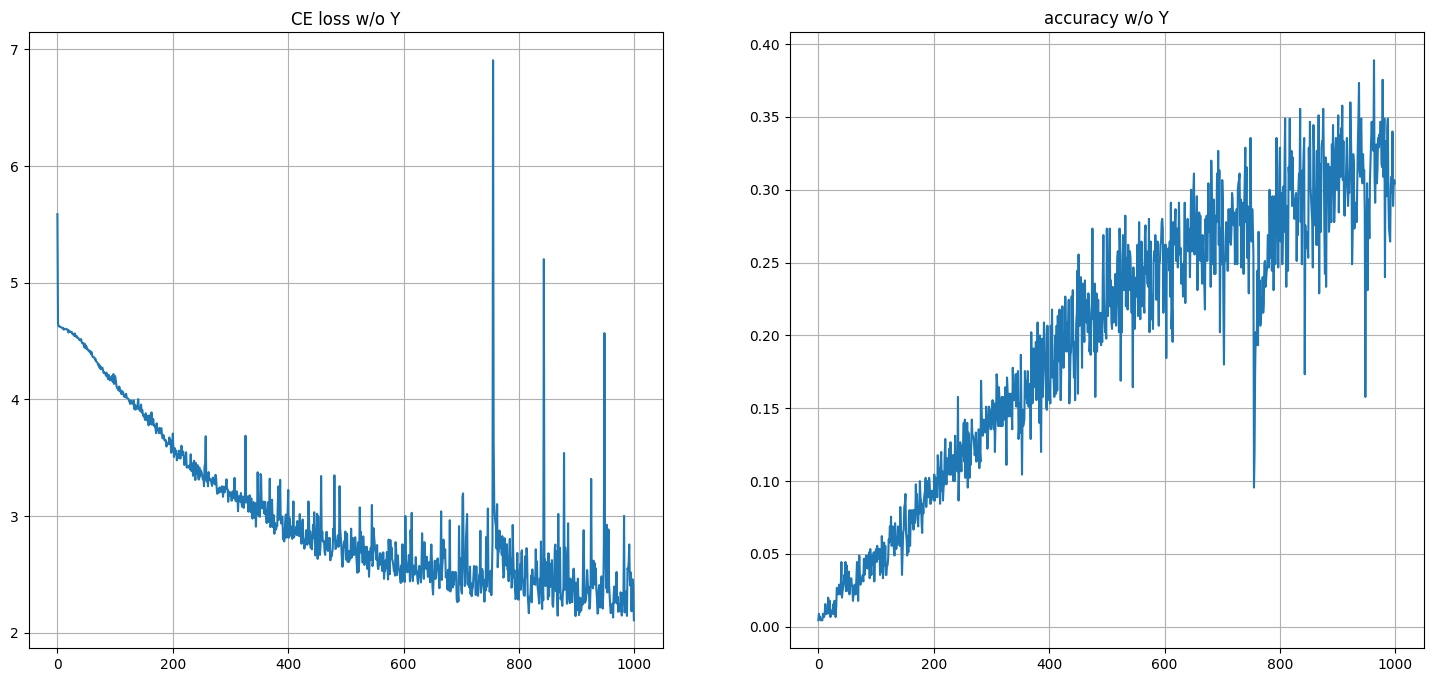

In [ ]:
diabModel = DiabetesModel(input_size=10, output_size=num_classes, activation=activation)
loss, accuracy = getLossAndAccuracy(diabModel, epochs, diabetesDataLoader, device, drop_Y = True)
performance_plot(loss, accuracy, 'w/o Y')

# Plot graph of model with Y Included



Model params:
tensor_0_shape=torch.Size([32, 11])
tensor_1_shape=torch.Size([32])
tensor_2_shape=torch.Size([16, 32])
tensor_3_shape=torch.Size([16])
tensor_4_shape=torch.Size([100, 16])
tensor_5_shape=torch.Size([100])
number of model params  2612


training... epoch 951 of 1000 loss= 1.2526522874832153 acc=0.5444444417953491: 100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


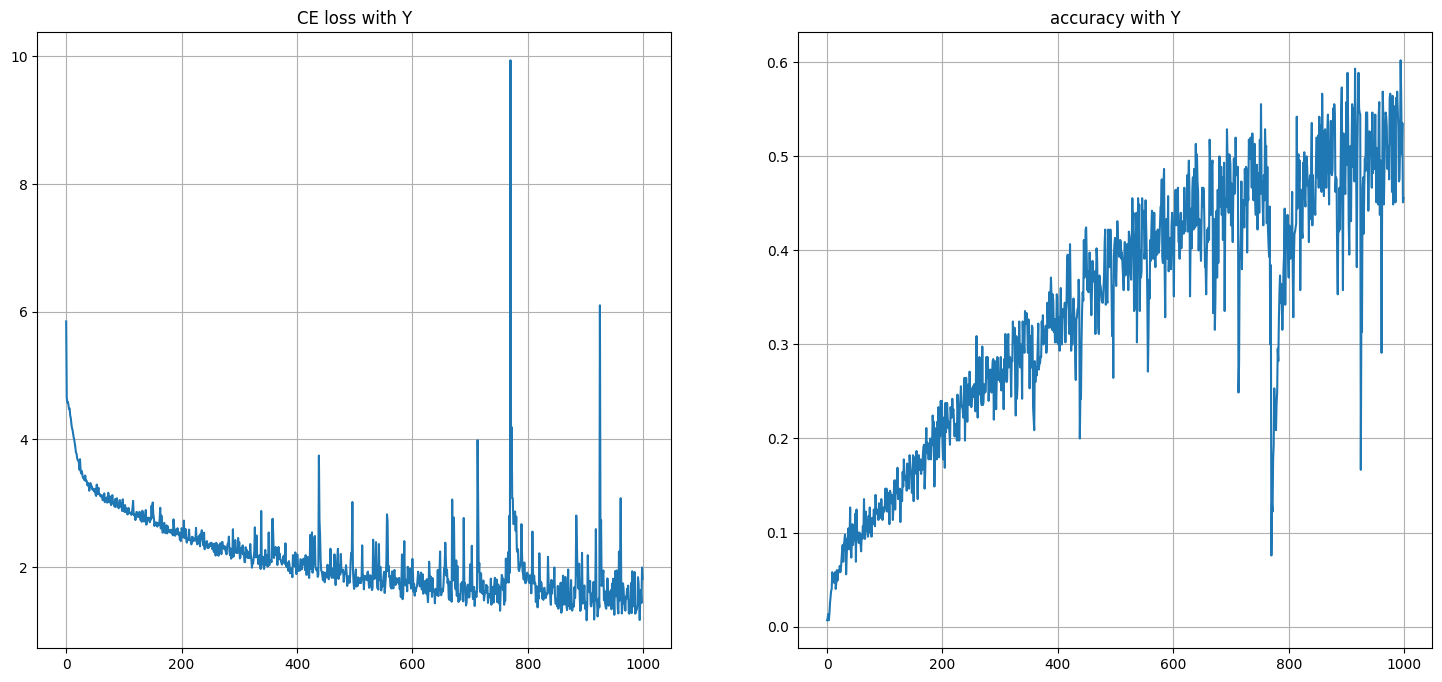

In [ ]:
diabModel = DiabetesModel(input_size=11, output_size=num_classes, activation=activation)
loss, accuracy = getLossAndAccuracy(diabModel, epochs, diabetesDataLoader, device, drop_Y = False)
performance_plot(loss, accuracy, 'with Y')

# Defining the training set and test set

---



In [ ]:
diab_training_df = diabetes_df.sample(frac=0.8, random_state=23)
diab_testing_df = diabetes_df.drop(diab_training_df.index)

diab_train_dataset = DiabetesDataset(diab_training_df, transform=transform)
diab_test_dataset = DiabetesDataset(diab_testing_df, transform=transform)

train_dataloader = DataLoader(diab_train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(diab_test_dataset, batch_size=10, shuffle=False)

diabModelYIncluded = DiabetesModel(11, output_size=num_classes, activation = activation)
diabModelYExcluded = DiabetesModel(10, output_size=num_classes, activation = activation)

# **Training on 80% training set with Y parameter excluded**



Model params:
tensor_0_shape=torch.Size([32, 10])
tensor_1_shape=torch.Size([32])
tensor_2_shape=torch.Size([16, 32])
tensor_3_shape=torch.Size([16])
tensor_4_shape=torch.Size([100, 16])
tensor_5_shape=torch.Size([100])
number of model params  2580


training... epoch 951 of 1000 loss= 2.2209439277648926 acc=0.37638887763023376: 100%|██████████| 1000/1000 [01:47<00:00,  9.34it/s]


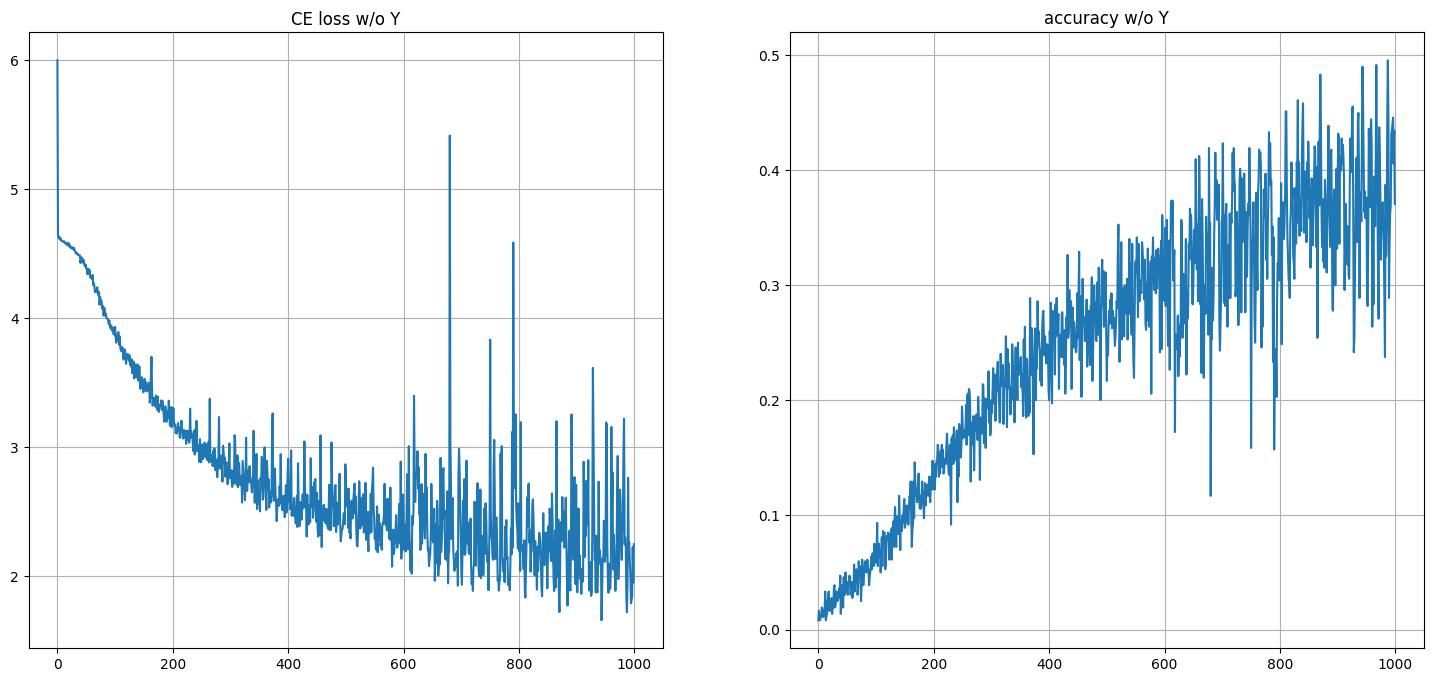

In [ ]:
loss, accuracy = getLossAndAccuracy(diabModelYExcluded, epochs, train_dataloader, device, drop_Y = True)
performance_plot(loss, accuracy, 'w/o Y')

# **Training on 80% training set with Y parameter included**



Model params:
tensor_0_shape=torch.Size([32, 11])
tensor_1_shape=torch.Size([32])
tensor_2_shape=torch.Size([16, 32])
tensor_3_shape=torch.Size([16])
tensor_4_shape=torch.Size([100, 16])
tensor_5_shape=torch.Size([100])
number of model params  2612


training... epoch 951 of 1000 loss= 2.45883846282959 acc=0.43333330750465393: 100%|██████████| 1000/1000 [01:45<00:00,  9.51it/s]


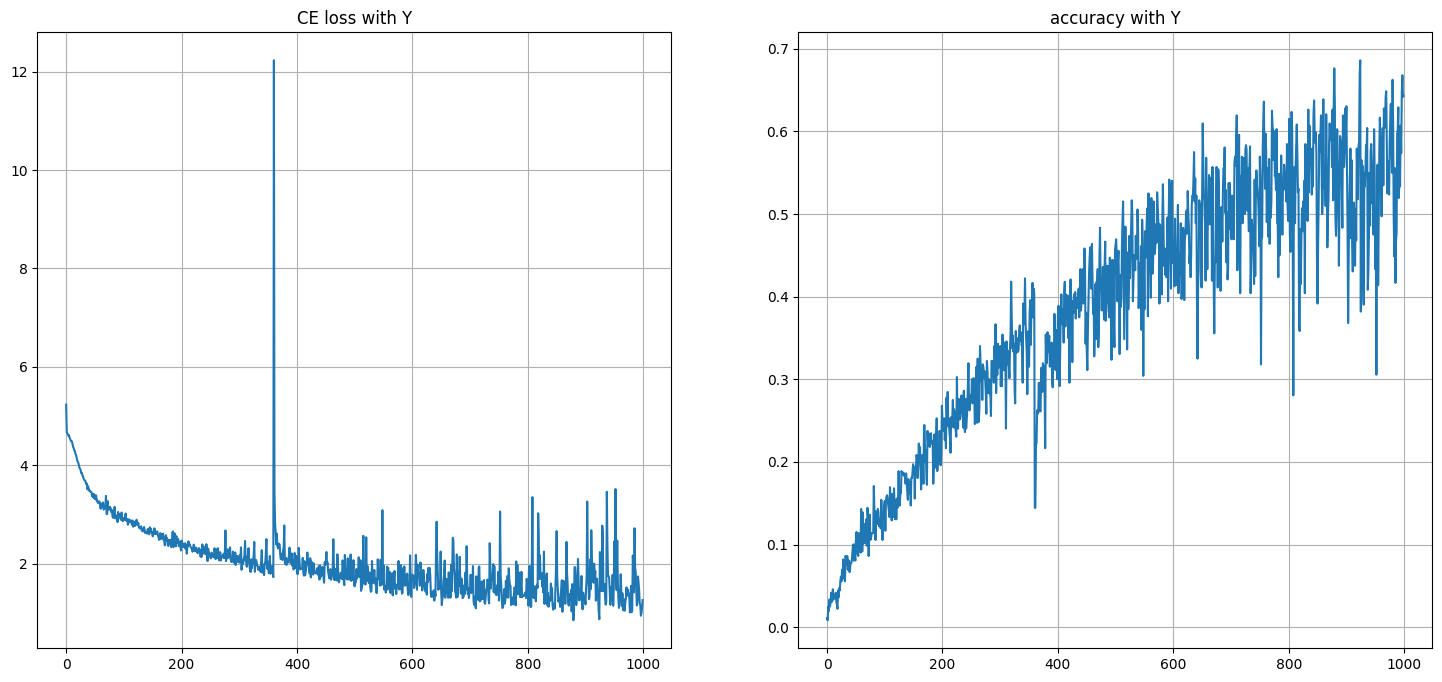

In [ ]:
loss, accuracy = getLossAndAccuracy(diabModelYIncluded, epochs, train_dataloader, device, drop_Y = False)
performance_plot(loss, accuracy, 'with Y')

In [ ]:
loss, accuracy = test(test_dataloader, diabModelYExcluded, device, drop_Y=True)
print_statstics(loss, 'loss w/o Y' )
print_statstics(accuracy, 'accuracy w/o Y' )

loss w/o Y: mean = 21.633256912231445 and the std = 8.228506088256836
accuracy w/o Y: mean = 0.011111111380159855 and the std = 0.03333333507180214


In [ ]:
loss, accuracy = test(test_dataloader, diabModelYIncluded, device, drop_Y=False)
print_statstics(loss, 'loss with Y' )
print_statstics(accuracy, 'accuracy with Y' )

loss with Y: mean = 17.10167694091797 and the std = 5.745652675628662
accuracy with Y: mean = 0.0694444477558136 and the std = 0.0726483166217804


# **סעיף יד**

I would rather use deciles then precentiles, the reason is that for precentiles there is much more need for precision, we have a 400 example dataset deviding by 100 means we will get approximately 4 examples per class which will end up in not enough data for the test, it will be have badly on the test.

# **Bonus Question**

In [ ]:
from torch.utils.data import DataLoader
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device used', device)


device used cpu


In [ ]:
diabetes_df = pd.read_csv(os.path.join(dir,labels_file), sep='\t')
# normalize output to [0,1] range
Y_max = diabetes_df['Y'].max()
diabetes_df['Y'] = diabetes_df['Y']/Y_max
print('Maximal Y score ', Y_max)


In [ ]:
class DiabetesRegDataset(Dataset):
  
  def __init__(self, diabetes_df, transform=None, target_transform=None):
    self.transform = transform
    self.target_transform = target_transform
    self.diabetes_df = diabetes_df
    
  def __len__(self):
    return len(self.diabetes_df)

  def __getitem__(self, idx):
    #print("THE ID: ", idx)
    sample = self.diabetes_df.iloc[idx].to_numpy()
    if self.transform:
      sample = self.transform(sample)
    
    label = torch.tensor(sample[-1], dtype=torch.float32)
    features = torch.tensor(sample[:-1], dtype=torch.float32)
    return features, label

In [ ]:
diab_training_df = diabetes_df.sample(frac=0.8, random_state=23)
diab_testing_df = diabetes_df.drop(diab_training_df.index)

diab_train_dataset = DiabetesRegDataset(diab_training_df, transform=None)
diab_test_dataset = DiabetesRegDataset(diab_testing_df, transform=None)

train_dataloader = DataLoader(diab_train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(diab_test_dataset, batch_size=10, shuffle=False)

print("Number of batches in training ", len(train_dataloader))
print("Number of batches in testing ", len(test_dataloader))

Number of batches in training  36
Number of batches in testing  9


In [ ]:
class DiabetesRegresModel(torch.nn.Module):
    def __init__(self, input_size, activation=torch.nn.ReLU(), with_bias=True):
        super(DiabetesRegresModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32, bias=with_bias),
            activation,
            nn.Linear(32, 16, bias=with_bias),
            activation,
            nn.Linear(16, 1, bias=with_bias),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [ ]:
activation = nn.LeakyReLU(0.01)
diabRegModel = DiabetesRegresModel(input_size=10, activation = activation)
printDiabetesModelParams(diabRegModel)




Model params:
tensor_0_shape=torch.Size([32, 10])
tensor_1_shape=torch.Size([32])
tensor_2_shape=torch.Size([16, 32])
tensor_3_shape=torch.Size([16])
tensor_4_shape=torch.Size([1, 16])
tensor_5_shape=torch.Size([1])
number of model params  897


In [ ]:
def iterate_regres_train_batch(optimizer, regres_loss, diabModel, features, labels):
  optimizer.zero_grad()
  score = diabModel(features)

  loss = regres_loss(score, labels)
  loss.backward()
  optimizer.step()
  return loss.detach()

# Train Single Epoch:
def train_single_reg_epoch(train_dataloader, optimizer, regres_loss, diabModel, device):
  num_batches = len(train_dataloader)
  #print("The number of batches is ", num_batches)
  loss = torch.zeros(num_batches)
  for idx, (features, labels) in enumerate(train_dataloader):
    features, labels = features.to(device), labels.to(device)
    loss[idx] = iterate_regres_train_batch(optimizer, regres_loss, diabModel, features, labels)
  return loss

In [ ]:
from tqdm import tqdm
epochs = 4000
num_records = 20
nun_epochs_report = int(epochs/num_records)

def training_reg(epochs, train_dataloader, optimizer, regres_loss, diabModel, device):
  loss_train = []
  loss_train_ep = torch.zeros(epochs)

  diabModel = diabModel.to(device)
  for ne in (pbar := tqdm(range(epochs))):
    loss = train_single_reg_epoch(train_dataloader, optimizer, regres_loss, diabModel, device)
    loss_train.append(loss)
    loss_train_ep[ne] = loss.mean()
    if ne % nun_epochs_report == 0:
      pbar.set_description(f"training... epoch {ne + 1} of {epochs} loss= {loss_train_ep[ne]}")
  return loss_train_ep, torch.cat(loss_train)

In [ ]:
def getRegresLoss(diabRegModel, epochs, diabetesDataLoader, device,   regres_loss = nn.MSELoss()):
  optimizer = torch.optim.SGD(diabRegModel.parameters(), lr=0.01)
  output = training_reg(epochs, diabetesDataLoader, optimizer, regres_loss, diabRegModel, device=device)
  loss = output[0]
  return loss

In [ ]:
import matplotlib_inline
import matplotlib.pyplot as plt

def performance_reg_plot(loss, text=''):
  fig = plt.figure(figsize=(8,8))
  plt.plot(loss)
  plt.grid()
  plt.title('loss ' + text)


  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
training... epoch 3801 of 4000 loss= 0.048868414014577866: 100%|██████████| 4000/4000 [04:57<00:00, 13.46it/s]


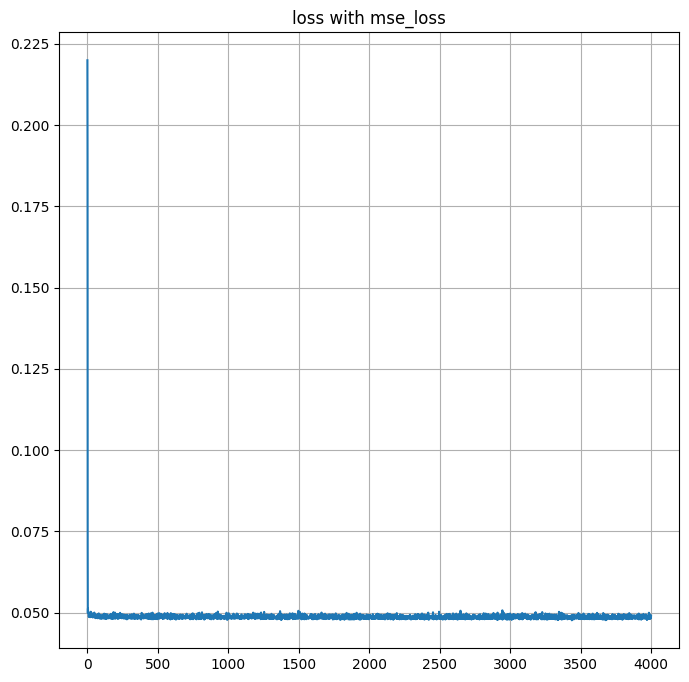

In [ ]:
regres_loss, regres_loss_name = nn.MSELoss(), 'mse_loss'
loss = getRegresLoss(diabRegModel, epochs, train_dataloader, device, regres_loss=regres_loss)
performance_reg_plot(loss, 'with '+regres_loss_name)

In [ ]:
def iterate_test_batch(optimizer, regres_loss, diabModel, features, labels):
  score = diabModel(features)
  loss = regres_loss(score, labels)
  return loss.detach()

def test(dataloader, diabModel, device, regres_loss):
  optimizer = torch.optim.SGD(diabModel.parameters(), lr=0.01)
  num_batches = len(dataloader)
  loss = torch.zeros(num_batches)
  for idx, (features, labels) in enumerate(dataloader):
    features, labels = features.to(device), labels.to(device)
    loss[idx] = iterate_test_batch(optimizer, regres_loss, diabModel, features, labels)
  return loss




In [ ]:
loss = test(test_dataloader, diabRegModel, device, regres_loss)
def print_statistics(x, text):
  print('{}: mean = {} and the std = {}'.format(text, x.mean(), x.std()))

print_statistics(loss,regres_loss_name)

mse_loss: mean = 0.053021177649497986 and the std = 0.015779700130224228
